In [1]:
import cv2
import re
import pytesseract
import numpy as np
from matplotlib import pyplot as plt
from pytesseract import Output

In [2]:
img = cv2.imread('./cupom2.jpg')

In [3]:
custom_config = r'--oem 3 --psm 6 -l por'
pytesseract.image_to_string(img, config=custom_config)

'LOJAS RENHER S.A.\nAU. ASSIS BRASIL, 1010 - PORTO ALEGRE - RS\nCNPJ:92.754.738/0013-04 1E:096/0372202\n03/05/2073 10:05:40  CCF:002200 CO0:010169\nCUPOM FISCAL\n\nITEM CÓDIGO DESCRIÇÃO\nQTD. UN. UL.UNITC R$) ST IAT UL.ITENC R$)\n001 530236310 Blusa n3 4\n\n1,000Un x 89,90 TO4 A 89,90%:\n002 520196220 PERFUME PA\n\n1,000Un x 199,00 FI à 199,00:\nTOTAI RE 288,90\nDinheiro 288,90\nT04=17,00%\nHD5: Ib34ecabO54dO bi fdBac75edOe3dIF1\nTotal Inpostos Pagos “R$116,56 (40,35%)Fonte: IBPT\nuuu. Tojasrenner.con.br\nLJ Otavio Rocha\n0P:014789-SANDRA NU: 001644\nVYT2DXSNROGT-R/hB420X-pb=SAXVYR&BR-Vx9ux>T=T==>\n2Ph 2PN/2EFC LOGRER ECF-IF\nVERSÃO: 03.04.00 ECF:014 LJ:0015 OPR:B\nSSSSSS5SSS IPGHONSE 03/05/2013 10:05:52\nFAB:ZP030501143 Pt\n\x0c'

### Retorna imagem em tons de cinza

In [4]:
def get_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Remoção de ruído

In [5]:
def remove_noise(img):
    return cv2.medianBlur(img, 5)

### Thresholding

In [6]:
def thresholding(img):
    return cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]

### Dilation

In [7]:
def dilate(img):
    kernel = np.ones((5,5), np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

### Erosion

In [8]:
def erode(img):
    kernel = np.ones((5,5), np.uint8)
    return cv2.erode(img, kernel, iterations = 1)

### opening -> erosion + dilation

In [9]:
def opening(img):
    kernel = np.ones((5,5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

### Canny edge detection

In [10]:
def canny(img):
    return cv2.Canny(img, 100, 200)

### Skew correction

In [11]:
def deskew(img):
    coords = np.column_stack(np.where(img > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.wapAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

### Match template

In [12]:
def match_template(img, template):
    return cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)

## Workspace:

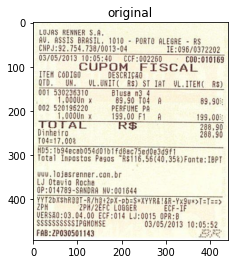

In [13]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('original')
plt.show()

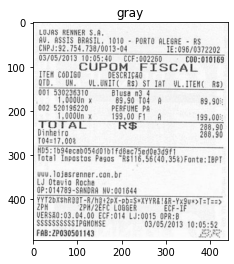

In [14]:
gray = get_grayscale(img)
gray_rgb = cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)
plt.imshow(gray_rgb)
plt.title('gray')
plt.show()

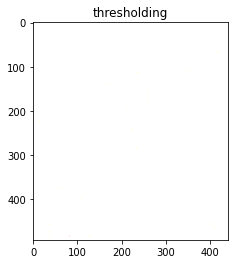

In [15]:
thresh = thresholding(img)
thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)
plt.imshow(thresh_rgb)
plt.title('thresholding')
plt.show()

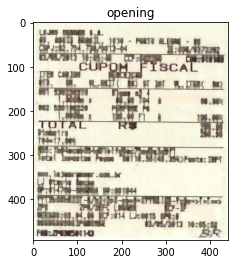

In [16]:
opening = opening(img)
opening_rgb = cv2.cvtColor(opening, cv2.COLOR_BGR2RGB)
plt.imshow(opening_rgb)
plt.title('opening')
plt.show()

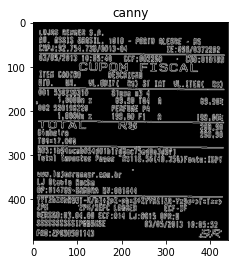

In [17]:
canny_ = canny(img)
canny_rgb = cv2.cvtColor(canny_, cv2.COLOR_BGR2RGB)
plt.imshow(canny_rgb)
plt.title('canny')
plt.plot(4,4)
plt.show()

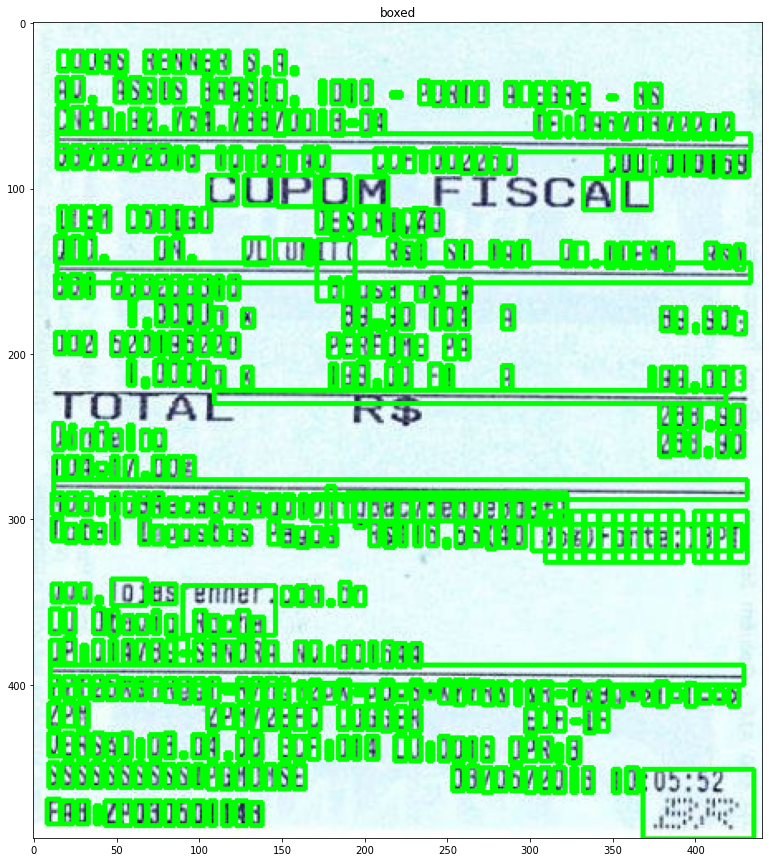

In [18]:
h, w, c = img.shape
box_img = img
boxes = pytesseract.image_to_boxes(box_img) 
for b in boxes.splitlines():
    b = b.split(' ')
    box_img = cv2.rectangle(box_img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)


plt.figure(figsize = (25,15))
plt.imshow(box_img)
plt.title('boxed')
plt.plot(8,8)
plt.show()

"-"
"CUPOM"
"SC"
" "
"é"
" "
"do"
"tos"
"RS"
"mor"
" "
"  "
"  "
"E"
" "
" "
" "
"-+"
"f"
""


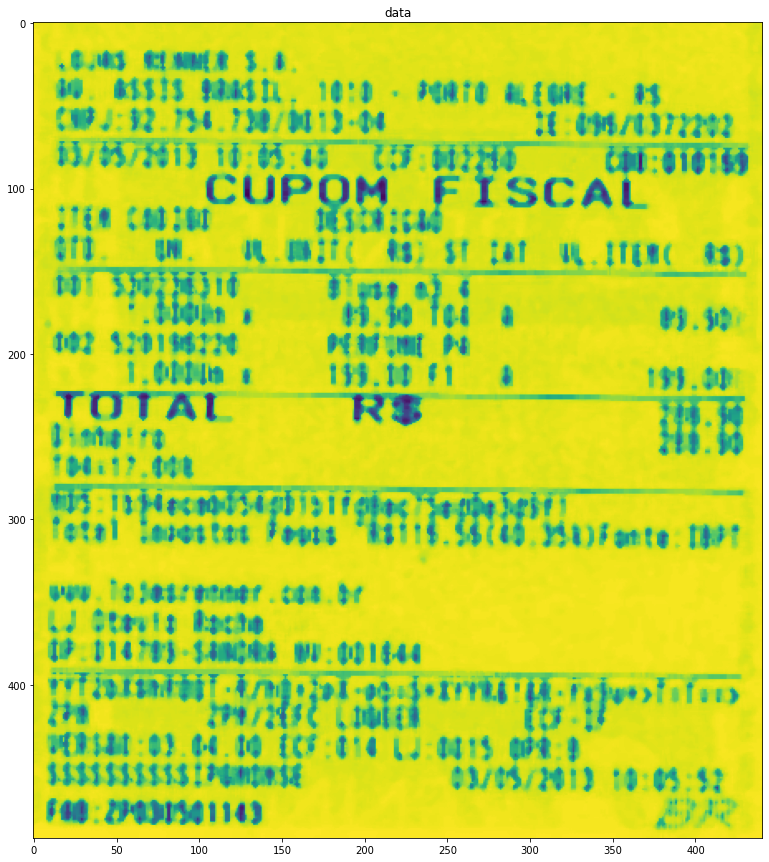

In [26]:
h, w, c = img.shape

des_img = cv2.imread('cupom2.jpg')
# des_img = deskew(cv2.imread('cupom2.jpg'))
# des_img_rgb = cv2.cvtColor(des_img, cv2.COLOR_BGR2RGB)
gray_img = get_grayscale(des_img)
cann = canny(gray_img)
box_word_img = gray_img

my_config={'keep_default_na': False, 'na_values': ["nan"]}
d = pytesseract.image_to_data(box_word_img, output_type=Output.DICT, lang='por')
date_pattern = '^(0?[1-9]|[12][0-9]|3[01])[\/\-](0?[1-9]|1[012])[\/\-]\d{4}$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if float(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        # box_word_img = cv2.rectangle(box_word_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        texto = d['text'][i]
        print(f'"{texto}"')
        if re.match(date_pattern, texto):
            print(f'Data: {texto}')
            box_word_img = cv2.rectangle(box_word_img, (x, y), (x + w, y + h), (0, 255, 0), 2)


plt.figure(figsize = (25,15))
plt.imshow(box_word_img)
plt.title('data')
plt.plot(8,8)
plt.show()